In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imdb
from PIL import Image
import requests
from fuzzywuzzy import fuzz, process

C:\Users\dougm\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# load data
rated_movies_org = pd.read_csv('../Data/rated_movies_org.csv.gz', low_memory = False)
rated_movies = pd.read_csv('../Data/rated_movies.csv.gz', low_memory = False)
people = pd.read_csv('../Data/people.csv.gz', low_memory = False)
roles = pd.read_csv('../Data/roles.csv.gz', low_memory = False)
sim_feat = np.load('../Data/cosine_sim_features.npy')

In [3]:
indices = pd.Series(rated_movies.index, index = rated_movies.original_title)

In [4]:
# function that recommends similar movies based of movie title input
def get_recommendations(title):
    if title in indices:
        # index of the movie that matches the title
        idx = indices[title]
        idx_check(idx, title)
    else:
        suggested = is_this_your_movie(title)
        print('I am sorry, but I could not find {}. Did you mean {}?'.format(title, suggested[0][0]))
        answer = input('Y or N: ')
        if answer == 'Y':
            print(str(suggested[0][0]))
            get_recommendations(str(suggested[0][0]))
        elif answer == 'N':
            print('Maybe it is this one, {}?'.format(suggested[1][0]))
            answer2 = input('Y or N: ')
            if answer2 == 'Y':
                get_recommendations(suggested[1][0])
            else:
                 print("I guess we'll never know")
    
    
# to process movie info and format thumbnail poster
def process_movie(movie):
    access = imdb.IMDb()
    movie_id = int((''.join(str(i) for i in movie.imdb_title_id)).lstrip("tt").lstrip("0"))
    film = access.get_movie(movie_id)

    thumbnail = requests.get(film['cover url'], stream=True)
    img = Image.open(thumbnail.raw)   
    
    plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
    plt.tick_params(axis = 'y', which = 'both', right = False, left = False, labelleft = False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)

    plt.imshow(img)
    plt.show()
    
    print('Director:', (', '.join(str(i) for i in movie.director)))
    print('Cast:', (', '.join(str(i) for i in movie.actors)))
    if 'plot outline' not in film.keys():
        print('Plot:', (','.join(str(i) for i in movie.description)))
    else:
        print('Plot:', film['plot outline'])
    print('Genre:', (','.join(str(i) for i in movie.genre)))
    print('IMDb Rating:', (','.join(str(i) for i in movie.weighted_average_vote)))
    
    
# function to return thumbnail and information about the movie
def tell_me_more(title):
    movie = rated_movies_org[rated_movies_org.original_title == title]
    if len(movie) == 1:
        process_movie(movie)
    elif len(movie) > 1:
        print('There are multiple movies by that name. Can you help me narrow it down?')
        print('Here are your choices:')
        print(movie[['original_title', 'year', 'director']])
        print('')
        yr = input('What year did the movie come out that you are looking for: ')
        movie = movie[movie.year == yr]
        process_movie(movie)
    else:
        suggested = is_this_your_movie(title)
        print('I am sorry, but I could not find {}. Did you mean {}?'.format(title, suggested[0][0]))
        answer = input('Y or N: ')
        if answer == 'Y':
            tell_me_more(suggested[0][0])
        elif answer == 'N':
            print('Maybe it is this one, {}?'.format(suggested[1][0]))
            answer2 = input('Y or N: ')
            if answer2 == 'Y':
                tell_me_more(suggested[1][0])
            else:
                print("I guess we'll never know")
        
        
# find similar string
def is_this_your_movie(title):
    title1 = title
    title2 = rated_movies.original_title.to_list()
    scores = process.extract(title1, title2, scorer = fuzz.token_set_ratio)
    return scores


def is_this_your_person(person):
    person1 = person
    person2 = people.name.to_list()
    scores = process.extract(person1, person2, scorer = fuzz.token_set_ratio)
    return scores


# idx check to account more multiple titles with same name
def idx_check(idx, title, cosine_sim = sim_feat):
    if idx.shape == ():
        # pairwise similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]
        movie_indices = [i[0] for i in sim_scores]
        # the top 5 most similar movies
        print('Here are some recommendations:', ", ".join(list(rated_movies['original_title'].iloc[movie_indices])))
    if idx.shape > (1, ):
        movie = rated_movies[rated_movies.original_title == title]
        print('There are multiple movies by that name. Can you help me narrow it down?')
        print('Here are your choices:')
        print(movie[['original_title', 'year', 'director', 'description']])
        print('')
        yr = input('What year did the movie come out that you are looking for: ')
        new_idx = movie[movie.year == yr]
        new_idx = np.int64(int(str(new_idx.index.values).strip('[').strip(']')))
        idx_check(new_idx, title)

In [5]:
# show me films with actor
def find_movies_by_actor(x):
    for i in range(len(people)):
        if people.name[i] == x:
            name_id = people.imdb_name_id[i]
    title_id = []
    for a in range(len(roles)):
        if (roles.imdb_name_id[a] in name_id) & ((roles.category[a] == 'actress') | (roles.category[a] == 'actor')):
            title_id.append(roles.imdb_title_id[a])
    list_of_films = rated_movies_org[rated_movies_org['imdb_title_id'].isin(title_id)]
    return ', '.join(str(i) for i in list_of_films.original_title)


# show me films by director
def find_movies_by_director(x):
    name_id = []
    for i in range(len(people)):
        if people.name[i] == x:
            name_id.append(people.imdb_name_id[i])
    title_id = []
    for d in range(len(roles)):
        if (roles.imdb_name_id[d] in name_id) & (roles.category[d] == 'director'):
            title_id.append(roles.imdb_title_id[d])
    list_of_films = rated_movies_org[rated_movies_org['imdb_title_id'].isin(title_id)]
    return ', '.join(str(i) for i in list_of_films.original_title)

In [6]:
# recommend movie by genre
def rec_movie_by_genre(x):
    movies_list = []
    for i in range(len(rated_movies)):
        if all(word in rated_movies.genre[i].lower() for word in x):
            movies_list.append([rated_movies.original_title[i], rated_movies.new_wav[i], 
                                rated_movies.total_votes[i], rated_movies.year[i], rated_movies.director[i]])
            movies_list.sort(key = lambda x:(x[2], x[1]), reverse=True)
    movies_list = [movies_list[0][0], movies_list[1][0], movies_list[2][0], movies_list[3][0], movies_list[4][0]]
    movies_list = ', '.join(str(i) for i in movies_list)
    return movies_list

In [7]:
find_movies_by_actor('Seth Rogen')

'Knocked Up, Monsters vs. Aliens, Pineapple Express, The Green Hornet, Zack and Miri Make a Porno, Paul, Observe and Report, Funny People, This Is the End, 50/50, Take This Waltz, The Guilt Trip, Sausage Party, Zeroville, Neighbors, Long Shot, The Interview, The Disaster Artist, The Night Before, Neighbors 2: Sorority Rising, The Lion King, An American Pickle'

In [8]:
find_movies_by_director('Oliver Stone')

'Seizure, The Hand, Platoon, Salvador, Wall Street, Talk Radio, Born on the Fourth of July, The Doors, JFK, Heaven & Earth, Natural Born Killers, Nixon, U Turn, Any Given Sunday, Alexander, World Trade Center, Wall Street: Money Never Sleeps, W., Savages, Snowden'

There are multiple movies by that name. Can you help me narrow it down?
Here are your choices:
      original_title  year                   director
11948        Seizure  1974               Oliver Stone
43718        Seizure  2016  Jamie Cymbal, Ryan Simons

What year did the movie come out that you are looking for: 1974


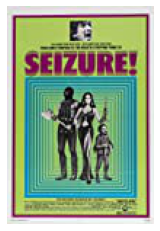

Director: Oliver Stone
Cast: Jonathan Frid, Martine Beswick, Joseph Sirola, Christina Pickles, Hervé Villechaize, Anne Meacham, Roger De Koven, Troy Donahue, Mary Woronov, Richard Cox, Timothy Ousey, Henry Judd Baker, Lucy Bingham, Alexis Kirk, Emil Meola
Plot: Jonathan Frid portrays a horror novelist who has a recurring nightmare about three figures out of his book who terrorize him and his family and friends during a weekend of fun. Then the dream becomes reality and it never ends...
Genre: Horror
IMDb Rating: 4.6


In [9]:
tell_me_more('Seizure')

In [10]:
get_recommendations('Star Wars')

Here are some recommendations: Star Wars: Episode VI - Return of the Jedi, Star Wars: Episode V - The Empire Strikes Back, Star Wars: Episode VII - The Force Awakens, Star Wars: Episode I - The Phantom Menace, Star Wars: Episode VIII - The Last Jedi
